# Scikit learn - ciąg dalszy
Przyjrzymy się tutaj dokładnie pojedynczym elementom jakich zbiorowo użyliśmy w zeszłym tygodniu oraz kilkoma nowymi featurami.

### Co analizujemy?
Analizujemy ten sam zbiór co ostatnio: https://www.kaggle.com/abcsds/pokemon

In [0]:
import io
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Załadowanie danych

In [101]:
from google.colab import files
uploaded = files.upload() # zbiór powinnyśmy w tym przypadku mieć na dysku

Saving Pokemon.csv to Pokemon (1).csv


In [0]:
data = pd.read_csv(io.StringIO(uploaded["Pokemon.csv"].decode('utf-8')))

In [0]:
data = data.iloc[:,2:]

In [104]:
data.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Grass,Poison,525,80,82,83,100,100,80,1,False
3,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Fire,NaN,309,39,52,43,60,50,65,1,False


## Podział danych

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:-1], data.iloc[:,-1])

## Usuwanie NaNów

In [0]:
mode = X_train.iloc[:,1].mode().iloc[0]
X_train.iloc[:,1] = X_train.iloc[:,1].fillna(value = mode)

In [0]:
X_test.iloc[:,1] = X_test.iloc[:,1].fillna(value = mode)

In [108]:
X_train.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
433,Grass,Flying,405,75,89,85,55,65,36,4
694,Dark,Dragon,300,52,65,50,45,50,38,5
111,Grass,Psychic,520,95,95,85,125,65,55,1
612,Ground,Dark,351,60,82,45,45,45,74,5
695,Dark,Dragon,420,72,85,70,65,70,58,5


In [109]:
X_test.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
711,Dragon,Ice,700,125,170,100,120,90,95,5
767,Rock,Dragon,521,82,121,119,69,59,71,6
660,Steel,Flying,300,40,55,70,45,60,30,5
44,Normal,Fairy,270,115,45,20,45,25,20,1
372,Water,Ground,468,110,78,73,76,71,60,3


## One hot encoding

In [0]:
X_train = pd.get_dummies(X_train, columns=["Type 1", "Type 2"])

In [0]:
X_test = pd.get_dummies(X_test, columns=["Type 1", "Type 2"])

In [112]:
X_train.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Type 1_Bug,Type 1_Dark,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
433,405,75,89,85,55,65,36,4,0,0,...,0,0,0,0,0,0,0,0,0,0
694,300,52,65,50,45,50,38,5,0,1,...,0,0,0,0,0,0,0,0,0,0
111,520,95,95,85,125,65,55,1,0,0,...,0,0,0,0,0,0,1,0,0,0
612,351,60,82,45,45,45,74,5,0,0,...,0,0,0,0,0,0,0,0,0,0
695,420,72,85,70,65,70,58,5,0,1,...,0,0,0,0,0,0,0,0,0,0


In [113]:
X_test.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Type 1_Bug,Type 1_Dark,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
711,700,125,170,100,120,90,95,5,0,0,...,0,0,0,1,0,0,0,0,0,0
767,521,82,121,119,69,59,71,6,0,0,...,0,0,0,0,0,0,0,0,0,0
660,300,40,55,70,45,60,30,5,0,0,...,0,0,0,0,0,0,0,0,0,0
44,270,115,45,20,45,25,20,1,0,0,...,0,0,0,0,0,0,0,0,0,0
372,468,110,78,73,76,71,60,3,0,0,...,0,0,1,0,0,0,0,0,0,0


In [117]:
set(X_test.columns).symmetric_difference(X_train.columns)

{'Type 1_Flying'}

In [130]:
(X_train.iloc[:,X_train.columns != "Type 1_Flying"].columns == X_test.columns).all()

True

In [0]:
X_train = X_train.iloc[:,X_train.columns != "Type 1_Flying"]

## Redukcja wymiarowości

In [132]:
X_train.shape

(600, 43)

### PCA

#### PCA i liczba zmiennych

In [0]:
pca = PCA(n_components = 10)

In [134]:
pca.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_train_pca = pca.transform(X_train) # tracimy Data Frama Pandasa

In [0]:
X_train_pca = pd.DataFrame(X_train_pca)

In [137]:
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-33.998440,29.595168,-18.635177,15.360136,-8.256127,-3.310340,0.660206,-0.445134,-0.157012,-0.459928
1,-147.453352,4.629561,-9.720299,7.025883,-8.490619,-9.576992,1.787082,0.567187,-0.012731,0.044905
2,91.219288,-8.158943,1.966223,31.934278,-34.658150,17.206642,-2.330967,0.583902,-0.367491,-0.169064
3,-93.194475,-19.944187,-27.216886,-5.540105,7.899975,-5.172274,1.772084,0.732696,0.044032,-0.024700
4,-18.093572,4.563245,-9.282718,7.645145,-1.207008,-6.054363,1.739466,0.543373,-0.018725,0.020451


#### PCA i wariancja

In [0]:
pca = PCA(n_components = 0.95, svd_solver = 'full')

In [139]:
pca.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [140]:
X_train_pca = pca.transform(X_train) # tracimy Data Frama Pandasa
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.head()

,0,1,2,3
0,-33.998440,29.595168,-18.635177,15.360136
1,-147.453352,4.629561,-9.720299,7.025883
2,91.219288,-8.158943,1.966223,31.934278
3,-93.194475,-19.944187,-27.216886,-5.540105
4,-18.093572,4.563245,-9.282718,7.645145


#### Wizualizacja danych przy użyciu PCA

In [141]:
pca = PCA(n_components = 2)
pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train) # tracimy Data Frama Pandasa
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.head()

,0,1
0,-33.998440,29.595168
1,-147.453352,4.629561
2,91.219288,-8.158943
3,-93.194475,-19.944187
4,-18.093572,4.563245


In [145]:
pca.explained_variance_ratio_.sum()

0.903295039275312

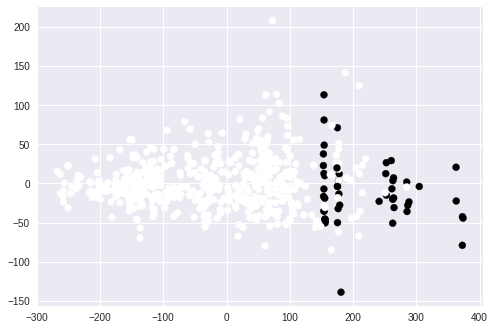

In [146]:
plt.scatter(X_train_pca[0], X_train_pca[1], c = y_train)

In [147]:
lr = LogisticRegression()
scores = cross_val_score(estimator = lr, X = X_train_pca, y = y_train, scoring = 'f1', cv = 5)
np.mean(scores)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.5374170720919946

### LDA

In [0]:
lda = LDA(n_components = 3)

In [149]:
lda.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=3, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [0]:
X_train_lda = lda.transform(X_train)

In [151]:
X_train_lda = pd.DataFrame(X_train_lda)
X_train_lda.head()

,0
0,-0.321811
1,-1.812131
2,0.857852
3,-1.015937
4,-0.845091


#### Wizualizacja danych przy użyciu LDA

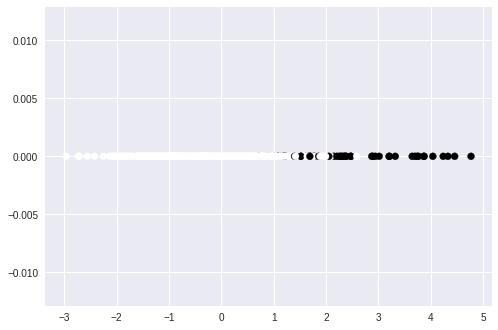

In [152]:
plt.scatter(X_train_lda, y = np.zeros(X_train_lda.size), c = y_train)

## Dobieranie hiperparametrów

Na przykładzie regresji logistycznej

In [153]:
lr = LogisticRegression()

lr_pipe = Pipeline([
    ('stdsc', StandardScaler()),
    ('pca', PCA(n_components = 0.95, svd_solver = 'full')),
    ('lr', lr)
])

param_grid = [
    {'lr__C': np.repeat(10.0,10) ** np.arange(-5,5)}
]

gs = GridSearchCV(estimator = lr_pipe,
                 param_grid = param_grid,
                 cv = 5,
                 scoring = 'f1',
                 n_jobs = -2)

gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardSc

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=...enalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid=[{'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [154]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [155]:
gs.param_grid

[{'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
         1.e+03, 1.e+04])}]

In [156]:
gs.cv_results_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([0.02070398, 0.02179561, 0.01800861, 0.01897941, 0.01729646,
        0.01821475, 0.02932296, 0.03603616, 0.06695957, 0.10937576]),
 'mean_score_time': array([0.0046258 , 0.00500035, 0.00680695, 0.00452209, 0.00522523,
        0.00238924, 0.00300155, 0.00330238, 0.00460954, 0.00275211]),
 'mean_test_score': array([0.5243781 , 0.54568488, 0.64834136, 0.5925    , 0.54048956,
        0.68590889, 0.68378621, 0.67562204, 0.67797273, 0.65507974]),
 'mean_train_score': array([0.56298971, 0.57881436, 0.66941045, 0.71218115, 0.72206217,
        0.82308861, 0.85920635, 0.886084  , 0.88352238, 0.89184969]),
 'param_lr__C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                    1000.0, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lr__C': 1e-05},
  {'lr__C': 0.0001},
  {'lr__C': 0.001},
  {'lr__C': 0.0

In [157]:
gs.best_params_

{'lr__C': 1.0}

In [0]:
lr_pipe = Pipeline([
    ('stdsc', StandardScaler()),
    ('pca', PCA(n_components = 0.95, svd_solver = 'full')),
    ('lr', LogisticRegression(C = 0.001))
])

## Predykcje

In [159]:
lr_pipe.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)), ('lr', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [161]:
y_pred = lr_pipe.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [167]:
(y_pred & y_test).sum() / y_pred.sum() # precyzja

0.4666666666666667

In [168]:
(y_pred & y_test).sum() / y_test.sum()

1.0

## Confusion matrix

In [0]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

In [174]:
cm

array([[170,  16],
       [  0,  14]])

Text(0,0.5,'actual')

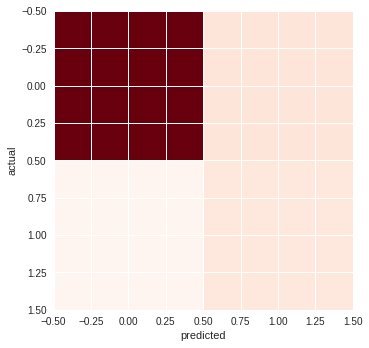

In [197]:
plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Reds)
plt.xlabel("predicted")
plt.ylabel("actual")

In [211]:
y_pred = np.array(lr_pipe.predict_proba(X_test))[:,1] > 0.55

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [213]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
cm

array([[182,   4],
       [  8,   6]])

Text(0,0.5,'actual')

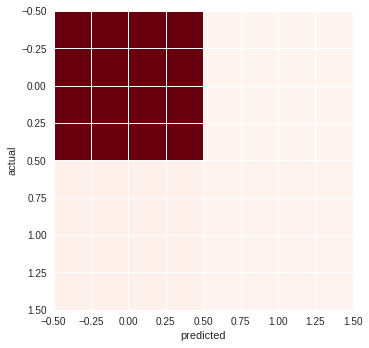

In [214]:
plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Reds)
plt.xlabel("predicted")
plt.ylabel("actual")